# Sidenote: Analyzing diversity indices to select a decoy contig

Before FDR estimation using the target-decoy approach, we'll need to actually select a decoy contig. `strainFlye fdr estimate` can do this for us, but here we perform this task manually.

What would make a good decoy contig? We can think of some basic rules—

1. A low number of "real" mutations
2. High coverage
3. High length

The first two of these criteria match up pretty well with the diversity indices we computed earlier, which—unlike the naïve mutations described in the BCF file—take coverage information into account. And the main tutorial already focuses on just "long" contigs with lengths of at least 1 Mbp, also.

So we're in good shape: we have this information already. (Well, we don't know for sure whether a mutation is "real" or not—that's the whole point of the FDR estimation stuff. But we have the other information, at least!)

If we provide our diversity index TSV file from `strainFlye call` to `strainFlye fdr estimate`, it can automatically select a decoy contig for us. We can also specify the decoy contig ourselves, if preferred.

For the sake of demonstration, we'll show one approach to using Python to analyze and plot the diversity indices we've already generated (as a way of looking for promising decoy contigs ourselves).

In [1]:
import pandas as pd
from math import ceil
from matplotlib import pyplot
# Make the plots look nice -- this is the style we use in the paper
pyplot.style.use("ggplot")

## Inspecting the file of diversity indices

First, we'll load the TSV file of diversity index information into a [pandas](https://pandas.pydata.org/) DataFrame.

In [2]:
di = pd.read_csv(
    "/Poppy/mfedarko/sftests/tutorial-output/call-p15/diversity-indices.tsv",
    sep="\t",
    index_col=0
)
di.head()

,AverageCoverage,Length,"DivIdx(p=50,minSuffCov=1000.0)","DivIdx(p=100,minSuffCov=500.0)","DivIdx(p=200,minSuffCov=250.0)","DivIdx(p=500,minSuffCov=100.0)","DivIdx(p=1000,minSuffCov=50.0)","DivIdx(p=2500,minSuffCov=20.0)","DivIdx(p=5000,minSuffCov=10.0)"
Contig,,,,,,,,,
edge_8,111.506924,1710962,NaN,NaN,NaN,0.001436,0.000751,1.344273e-05,0.000000e+00
edge_10,16.034630,1556982,NaN,NaN,NaN,NaN,NaN,NaN,2.211611e-05
edge_15,286.645095,3930935,NaN,NaN,NaN,0.001551,0.000631,1.282824e-04,2.590825e-07
edge_17,23.772577,1273557,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00
edge_28,21.984069,1624431,NaN,NaN,NaN,NaN,NaN,9.390465e-07,0.000000e+00


In [3]:
print(f"The dimensions of the DataFrame of diversity indices are {di.shape[0]:,} x {di.shape[1]:,}.")

The dimensions of the DataFrame of diversity indices are 468 x 9.


This DataFrame has dimensions (aka "shape") $C$x($D$ + 2), where $C$ is the number of contigs we performed mutation calling on (for SheepGut, 78,793) and $D$ is the number of values of $p$ included in `--div-index-p-list` (as of writing, this is 7 by default).

There are two extra columns included at the start of the DataFrame describing contigs' average coverages (only considering (mis)matches at a position, not indels) and lengths. Let's sort this DataFrame (in descending order, i.e. high to low) by average coverages.

In [4]:
di_cov_sorted = di.sort_values(["AverageCoverage"], ascending=False)
di_cov_sorted.head()

,AverageCoverage,Length,"DivIdx(p=50,minSuffCov=1000.0)","DivIdx(p=100,minSuffCov=500.0)","DivIdx(p=200,minSuffCov=250.0)","DivIdx(p=500,minSuffCov=100.0)","DivIdx(p=1000,minSuffCov=50.0)","DivIdx(p=2500,minSuffCov=20.0)","DivIdx(p=5000,minSuffCov=10.0)"
Contig,,,,,,,,,
edge_6104,4158.572469,1289244,0.000221,0.000064,0.000040,0.000027,0.000027,0.000000e+00,0.0
edge_2358,2993.461914,2806161,0.000581,0.000135,0.000040,0.000005,0.000002,1.069076e-06,0.0
edge_1371,2215.936973,1634973,0.001173,0.000991,0.000909,0.000651,0.000081,5.749330e-05,0.0
edge_23917,1987.798829,1020213,0.009018,0.003313,0.000775,0.000467,0.000306,0.000000e+00,0.0
edge_1671,1415.072755,2153394,0.011340,0.010501,0.008338,0.003400,0.000240,4.679987e-07,0.0


Since this file of diversity indices only covers "long" contigs with lengths ≥ 1 Mbp: the sorting-by-coverage operation shows us high-coverage, high-length contigs. This is nice! (For reference, `edge_6104`, `edge_1671`, and `edge_2358` correspond to CAMP, BACT1, and BACT2 from the paper, respectively.)

Let's do another sorting operation: this time, by the diversity index column corresponding to the lowest value of $p$ included (50, aka $p = (50 / 100) = 0.5\%$). We'll sort in ascending order this time, since we're interested in contigs with relatively low diversity indices.

In [5]:
di_final = di_cov_sorted.sort_values("DivIdx(p=50,minSuffCov=1000.0)")
di_final.head(10)

,AverageCoverage,Length,"DivIdx(p=50,minSuffCov=1000.0)","DivIdx(p=100,minSuffCov=500.0)","DivIdx(p=200,minSuffCov=250.0)","DivIdx(p=500,minSuffCov=100.0)","DivIdx(p=1000,minSuffCov=50.0)","DivIdx(p=2500,minSuffCov=20.0)","DivIdx(p=5000,minSuffCov=10.0)"
Contig,,,,,,,,,
edge_6104,4158.572469,1289244,0.000221,0.000064,0.000040,0.000027,0.000027,0.000000e+00,0.000000e+00
edge_16244,1318.792597,2448520,0.000297,0.000104,0.000083,0.000078,0.000063,1.266098e-05,0.000000e+00
edge_2358,2993.461914,2806161,0.000581,0.000135,0.000040,0.000005,0.000002,1.069076e-06,0.000000e+00
edge_1371,2215.936973,1634973,0.001173,0.000991,0.000909,0.000651,0.000081,5.749330e-05,0.000000e+00
edge_4773,1176.249727,1371455,0.001268,0.000947,0.000865,0.000841,0.000556,0.000000e+00,0.000000e+00
edge_11863,1057.411793,2597011,0.001933,0.000818,0.000670,0.000345,0.000208,1.136314e-04,3.898408e-07
edge_23917,1987.798829,1020213,0.009018,0.003313,0.000775,0.000467,0.000306,0.000000e+00,0.000000e+00
edge_1671,1415.072755,2153394,0.011340,0.010501,0.008338,0.003400,0.000240,4.679987e-07,0.000000e+00
edge_7349,1325.510426,1175877,0.012973,0.010487,0.008060,0.003285,0.001409,3.500673e-04,1.713526e-06


Nice! This confirms our finding in the paper that `edge_6104` (CAMP) has relatively high coverage and length, and a relatively low diversity index. `edge_16244` could also be useful as a decoy contig, but CAMP has a higher coverage and lower diversity indices (for all diversity index columns we analyzed). CAMP is shorter than `edge_16244`, but both contigs have lengths ≥ 1 Mbp—so it's not a big deal.

We've just shown one way of analyzing the diversity indices, by just inspecting a DataFrame of them—we could also plot diversity indices graphically, if desired. For completeness' sake, the following section shows an example of such a plot, but feel free to skip it.

## Plotting a histogram of diversity indices (using $p = 0.5\%$)

Note that this plot implicitly ignores contigs with `NA` diversity indices, at least for the $p = 0.5\%$ diversity index column. A contig could have a diversity index of `NA` (or `NaN`, as pandas displays it) if the diversity index isn't defined for this contig; this happens if a contig doesn't have enough sufficiently-covered positions for the $p$ or $r$ threshold used to compute this diversity index.

The histogram we'll plot here matches the second-from-the-bottom histogram shown in the diversity index figure in the paper (at least as of writing). Like in that figure, we'll highlight `edge_6104` to show how its diversity index compares to other contigs'.

(For comparison, the code that generated Figure 4 in the paper is located [here](https://nbviewer.org/github/fedarko/sheepgut/blob/main/notebooks/DiversityIndices.ipynb), although the data was produced using the paper's _ad hoc_ analysis code and not using strainFlye.)

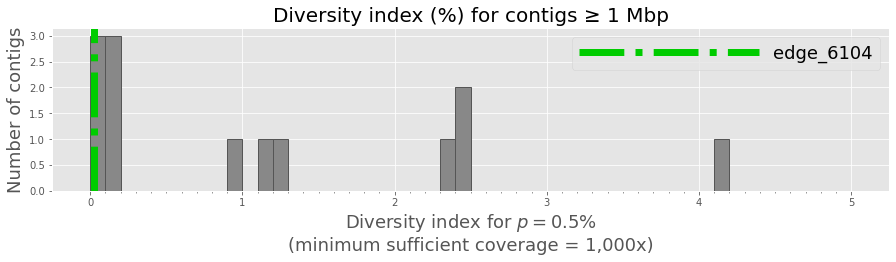

In [6]:
fig, ax = pyplot.subplots()

# You can change this to use a different column than p = 0.5%, if desired (although you should also
# update the x-axis label in this case).
DI_COL = "DivIdx(p=50,minSuffCov=1000.0)"

# Convert diversity indices to percentages
di_pcts = di_final[DI_COL] * 100

# Create a histogram bin for every 0.1%. Also add nice little ticks demarcating these bins.
max_di_pct = ceil(max(di_pcts))
bins = [x / 10 for x in range((max_di_pct * 10) + 1)]

# Highlight edge_6104 (assuming it's defined for this diversity index, which it should be)
if not pd.isna(di_pcts["edge_6104"]):
    ax.axvline(di_pcts["edge_6104"], color="#00cc00", lw=7, linestyle="-.", label="edge_6104")

ax.hist(di_pcts, bins=bins, color="#888888", lw=1, edgecolor="#555555")
ax.set_xticks(bins, minor=True)

ax.set_title("Diversity index (%) for contigs \u2265 1 Mbp", fontsize=20)
ax.set_xlabel("Diversity index for $p = 0.5\%$\n(minimum sufficient coverage = 1,000x)", fontsize=18)
ax.set_ylabel("Number of contigs", fontsize=18)
ax.legend(handlelength=10, fontsize=18)
fig.set_size_inches(15, 3)

Not a lot of contigs have defined diversity indices at $p = 0.5\%$; however, of those that do have defined diversity indices, there's a fairly wide range (from around 0% to around 4.1%).